# Modeling Days to Neutralization 
Two models used: 
1. Linear regression 
2. Neural Network with MAE/L1 loss and standardized for training

Next steps: 
- Feature engineering: find and exclude near-constant or dependent features 
- Exclude input variables that wouldn't be known at time of prediction 
- Random Forest / XGBoost 
- ElasticNet instead of linear regression 

In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
data_directory = "../Data/unh_hackathon_prompt_2_data.json"
sys.path.append("../UNH-Hackathon-2026-Group-3/")

## preparing the data


In [3]:
def load_predictive_warfighting_data(file_path: str = "unh_hackathon_prompt_2_data.json") -> pd.DataFrame:
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_json(file_path)

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the DataFrame by converting data types."""

    # Convert the string "NULL" to pd.NA
    df = df.replace("NULL", pd.NA)
    df = df.replace("N/A", pd.NA)

    for numeric_string_column in [
        "Enemy.Capability.Index",
        "EW_Capability",
        "Intel Confidence",

    ]:
        df[numeric_string_column] = pd.to_numeric(df[numeric_string_column])

    for boolean_string_column in [
        "response_success"
    ]:
        df[boolean_string_column] = df[boolean_string_column].map({"Yes": 1, "No": 0, "1": 1, "0": 0})

    return df

In [4]:
dirty_df = load_predictive_warfighting_data(data_directory)
df = clean_data(dirty_df)

# combine "Naval", "  naval", and "naval" into same category 
df["Threat Type"] = df["Threat Type"].str.strip()  # Remove leading/trailing whitespace
df["Threat Type"] = df["Threat Type"].str.lower()  # Convert to lowercase for consistency

# combine missile and msl into same threat type 
df["Threat Type"] = df["Threat Type"].replace({"msl": "missile"})

threat_type_counts = df["Threat Type"].value_counts()

# remove rows with nan values in any column 
df = df.dropna()

In [5]:
# combine "Naval", "  naval", and "naval" into same category 
df["Threat Type"] = df["Threat Type"].str.strip()  # Remove leading/trailing whitespace
df["Threat Type"] = df["Threat Type"].str.lower()  # Convert to lowercase for consistency

# combine missile and msl into same threat type 
df["Threat Type"] = df["Threat Type"].replace({"msl": "missile"})

threat_type_counts = df["Threat Type"].value_counts()

# remove rows with nan values in any column 
df = df.dropna()

In [6]:
# get array of values for input variables:
''' 
every column except output/results and categorical variables 
- also remove columns with nan values 
'''
input_columns = df.select_dtypes(include=[np.number]).columns.tolist()
input_columns.remove('response_success')
input_columns.remove('Financial_Loss_MUSD')
input_columns.remove('actual_days_to_stabilization')
input_columns = [col for col in input_columns if not df[col].isna().any()]
inputs = df[input_columns].values


# get array of values for output variables:
response_successes = df['response_success'].values
financial_loss_musds = df['Financial_Loss_MUSD'].values
actual_days_to_stabilizations = df['actual_days_to_stabilization'].values

output = actual_days_to_stabilizations

output[0]

np.float64(10.1)

In [7]:
df.head(5)

,Threat Type,enemy_unit_count,Enemy.Capability.Index,ThreatEscalationHours,friendlyUnitCount,LCS_COUNT,Aircraft Count,cyber_defense_teams,Patriot.Batteries,ISR_AssetCount,...,CMD_COORD_SCORE,roe_complexity_score,Operational Budget (MUSD),BudgetUtilization_pct,Weather_Severity,Theater Distance KM,Season,response_success,Financial_Loss_MUSD,actual_days_to_stabilization
0,missile,25,8,34,21,0,0,0,4,12,...,7,3,98,84,3,5164.8,Winter,1,388,10.1
1,missile,3,2,8,45,0,0,0,4,4,...,9,5,189,97,1,7149.7,Fall,1,244,2.0
2,air,7,3,48,45,0,5,0,0,14,...,9,1,92,88,0,6706.5,Winter,1,280,2.0
3,cyber,31,7,70,57,0,0,7,0,5,...,10,3,314,86,9,1851.9,Fall,1,330,5.3
4,hybrid,14,5,27,57,0,0,0,0,10,...,6,4,290,84,4,983.7,Spring,1,240,11.0


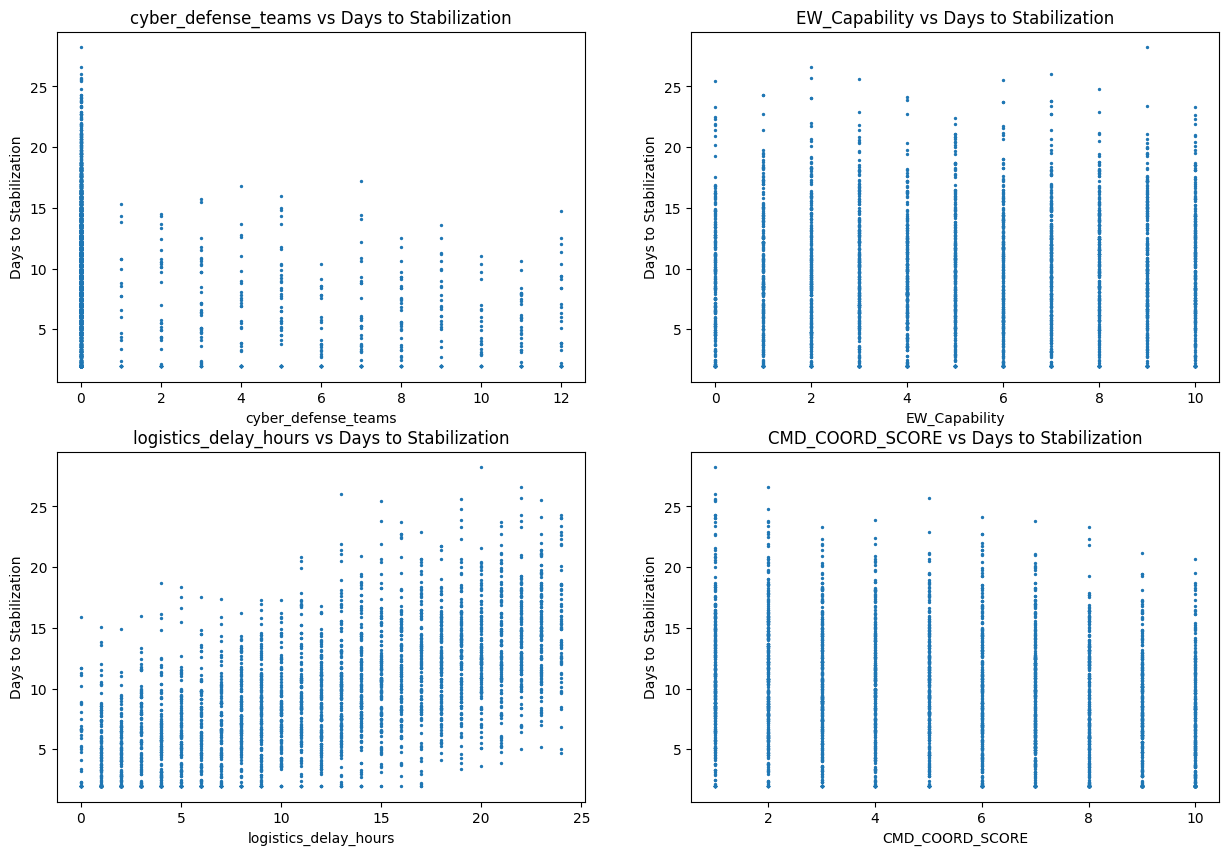

In [8]:
# plot input vs output for some input variables
input_names = [
    'cyber_defense_teams',
    'EW_Capability',
    'logistics_delay_hours',
    'CMD_COORD_SCORE'
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(df[input_names[i]], output, s=2)
    ax.set_xlabel(input_names[i])
    ax.set_ylabel("Days to Stabilization")
    ax.set_title(f"{input_names[i]} vs Days to Stabilization")

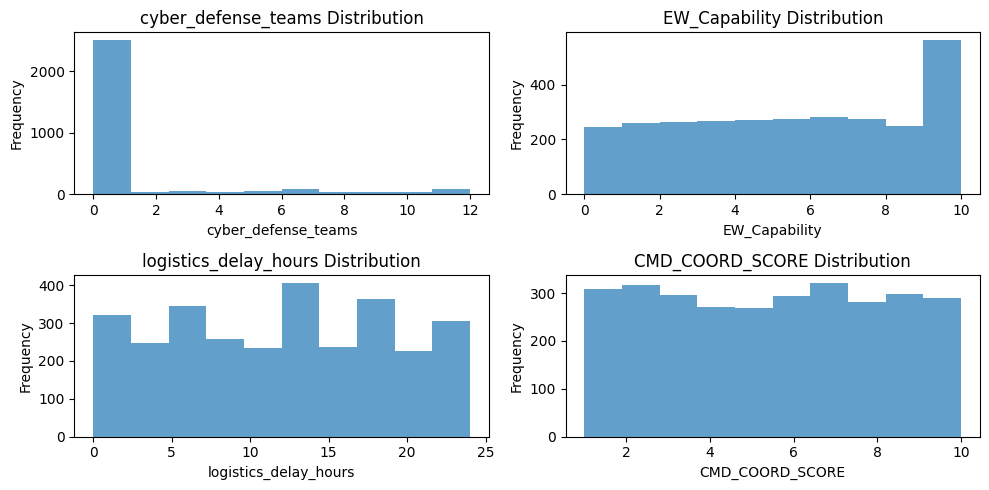

In [9]:
# histogram for some input variables
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df[input_names[i]], bins=10, alpha=0.7)
    ax.set_xlabel(input_names[i])
    ax.set_ylabel("Frequency")
    ax.set_title(f"{input_names[i]} Distribution")

plt.tight_layout()
plt.show()

## preparing + running the model to predict financial loss

In [10]:
min(output), max(output)

(np.float64(2.0), np.float64(28.2))

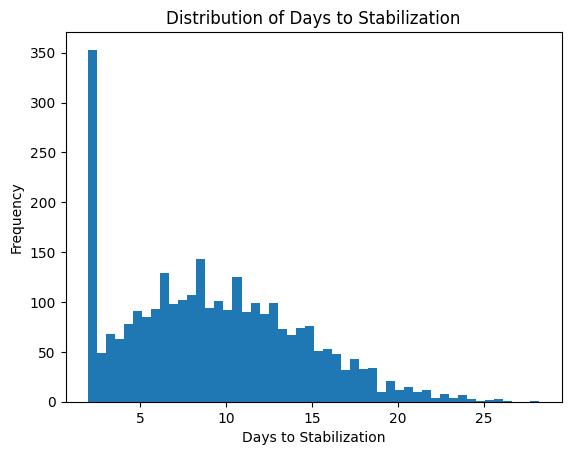

In [11]:
# visualize the distribution 
plt.hist(output, bins=50)
plt.xlabel("Days to Stabilization")
plt.ylabel("Frequency")
plt.title("Distribution of Days to Stabilization")
plt.show()

In [12]:
# scikit learn train test split implementation 
inputs_train, inputs_test, output_train, output_test = train_test_split(
    inputs, output, test_size=0.2, random_state=42)

inputs_train[0], output_train[0]

(array([3.0000e+01, 5.0000e+00, 2.9000e+01, 5.7000e+01, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+01, 5.7000e-01,
        1.0000e+00, 5.0000e+00, 4.4000e-01, 2.4000e+01, 8.1000e+01,
        9.7000e-01, 4.5000e+01, 1.0000e+00, 1.0000e+01, 3.0000e+00,
        5.4000e+01, 8.3000e+01, 0.0000e+00, 5.2534e+03]),
 np.float64(2.0))

In [13]:
# standardize 
train_input_means = np.mean(inputs_train, axis=0)
train_input_stds = np.std(inputs_train, axis=0)
inputs_train = (inputs_train - train_input_means) / (train_input_stds + 1e-8)
inputs_test = (inputs_test - train_input_means) / (train_input_stds + 1e-8)

train_output_mean = np.mean(output_train)
train_output_std = np.std(output_train)
output_train = (output_train - train_output_mean) / (train_output_std + 1e-8)
output_test = (output_test - train_output_mean) / (train_output_std + 1e-8)

inputs_train[0], output_train[0]

(array([ 0.30668271, -0.19667566, -0.39783589,  1.53510575, -0.47909972,
        -0.49471853,  0.37837363, -0.33682718,  0.60204725, -0.14561976,
        -1.58130083, -0.044019  , -1.48553301,  1.50385373,  0.62057173,
         1.60341588,  1.46994105, -1.58287932,  1.56033253,  0.0205849 ,
        -1.65892897,  0.26791034, -1.57632656, -0.00176667]),
 np.float64(-1.4528859548324986))

# basic linear regression 

In [ ]:
# linear regression model 
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(len(inputs[0]), 1)  # One in and one out

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
    
linearmodel = LinearRegressionModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(linearmodel.parameters(), lr=0.01)

for epoch in range(500):

    # Forward pass: Compute predicted y by passing 
    # x to the model
    pred_y = linearmodel(torch.Tensor(inputs_train))

    # Compute and print loss
    loss = criterion(pred_y, torch.Tensor(output_train))

    # Zero gradients, perform a backward pass, 
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([2356])) that is different to the input size (torch.Size([2356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 1.3857793807983398
epoch 1, loss 1.3703794479370117
epoch 2, loss 1.3556010723114014
epoch 3, loss 1.3414195775985718
epoch 4, loss 1.3278096914291382
epoch 5, loss 1.314748764038086
epoch 6, loss 1.3022143840789795
epoch 7, loss 1.2901846170425415
epoch 8, loss 1.278639554977417
epoch 9, loss 1.2675591707229614
epoch 10, loss 1.2569246292114258
epoch 11, loss 1.2467176914215088
epoch 12, loss 1.2369210720062256
epoch 13, loss 1.2275182008743286
epoch 14, loss 1.218492865562439
epoch 15, loss 1.2098300457000732
epoch 16, loss 1.201514720916748
epoch 17, loss 1.193532943725586
epoch 18, loss 1.1858712434768677
epoch 19, loss 1.1785165071487427
epoch 20, loss 1.1714563369750977
epoch 21, loss 1.164678931236267
epoch 22, loss 1.158172845840454
epoch 23, loss 1.1519269943237305
epoch 24, loss 1.1459307670593262
epoch 25, loss 1.140174150466919
epoch 26, loss 1.1346476078033447
epoch 27, loss 1.129341721534729
epoch 28, loss 1.124247670173645
epoch 29, loss 1.1193567514419556


## elasticnet

# torch.nn 

In [15]:
class NNmodel(nn.Module):
    def __init__ (self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(inputs_train[0]), 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)

        )

    def forward(self, x):
        # logits = self.linear_relu_stack(x)
        return self.linear_relu_stack(x)
    
class AbsDataset(Dataset):
    def __init__ (self, inputs, output):
        self.input_tensor = torch.tensor(inputs).float() 
        self.output_tensor = torch.tensor(output).float()
        
    def __len__(self):
        return len(self.output_tensor)
    
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx] 

In [16]:
train_dataset = AbsDataset(inputs_train, output_train)
test_dataset = AbsDataset(inputs_test, output_test)

# shuffles and batches 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# initiate model
nnmodel = NNmodel()
loss_func = nn.L1Loss()
optimizer = torch.optim.Adam(nnmodel.parameters(), lr=0.001) # learning rate


In [17]:
# training with per-epoch testing
training_loss_ls = []
test_loss_ls = []

epochs = 100

for epoch in range(epochs):
    epoch_loss_ls = []
    print("epoch #:", epoch)

    # training loop 
    nnmodel.train()
    for data, labels in train_loader:
        optimizer.zero_grad() # resets gradients in optimizer to 0 
        outputs = nnmodel(data)

        # calculate loss function (MSE)
        loss = loss_func(outputs, labels.unsqueeze(1))
        epoch_loss_ls.append(loss.item())
        loss.backward() # back prop 

        # optimizer 
        optimizer.step() # updates all parameters via gradient descent 
        
    avg_loss = np.average(np.array(epoch_loss_ls))
    print("average training loss:", avg_loss)
    training_loss_ls.append(avg_loss)
    
    # testing loop per epoch
    nnmodel.eval()
    test_epoch_ls = []
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = nnmodel(data)
            loss = loss_func(outputs, labels)
            test_epoch_ls.append(loss.item())
    
    avg_test_loss = np.average(np.array(test_epoch_ls))
    print("average test loss:", avg_test_loss)
    test_loss_ls.append(avg_test_loss)

epoch #: 0
average training loss: 0.702851377628945
average test loss: 0.5594810885701372
epoch #: 1


/Users/katherinesong/UNH-Hackathon-2026-Group-3/.venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average training loss: 0.47044327613469716
average test loss: 0.45165171860345654
epoch #: 2
average training loss: 0.40634453377208196
average test loss: 0.39798225936162046
epoch #: 3
average training loss: 0.3729078769683838
average test loss: 0.3827224694293606
epoch #: 4
average training loss: 0.3583522189307857
average test loss: 0.3716861168381162
epoch #: 5
average training loss: 0.34757692829982656
average test loss: 0.3616324863657482
epoch #: 6
average training loss: 0.3362307935147672
average test loss: 0.35675658759975676
epoch #: 7
average training loss: 0.3237173412297223
average test loss: 0.35037252506484706
epoch #: 8
average training loss: 0.3173163895671432
average test loss: 0.3490375693925421
epoch #: 9
average training loss: 0.3174367027508246
average test loss: 0.34060844947253505
epoch #: 10
average training loss: 0.30804435868520996
average test loss: 0.33741877487021005
epoch #: 11
average training loss: 0.3158052958346702
average test loss: 0.337148969271971

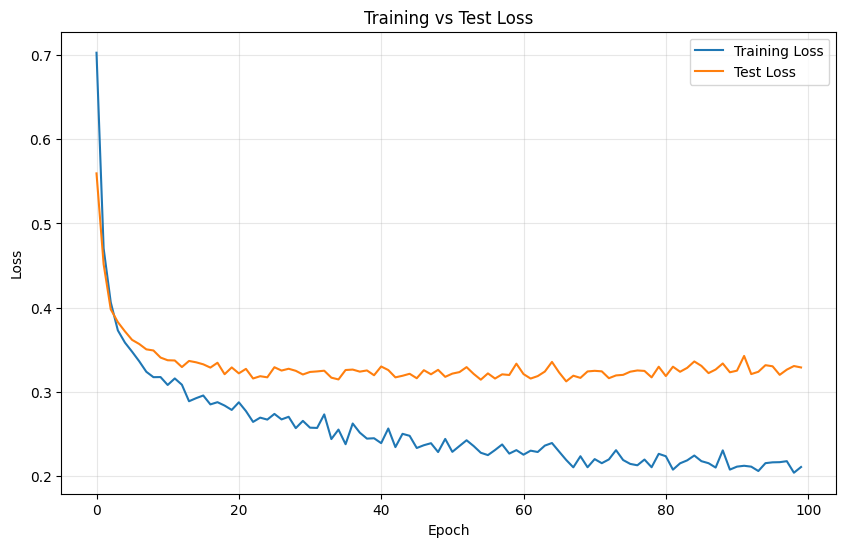

In [18]:
# Plot training and test loss together
x = range(epochs)
plt.figure(figsize=(10, 6))
plt.plot(x, training_loss_ls, label='Training Loss')
plt.plot(x, test_loss_ls, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.grid(True, alpha=0.3)
plt.show()

## visualizing the model 

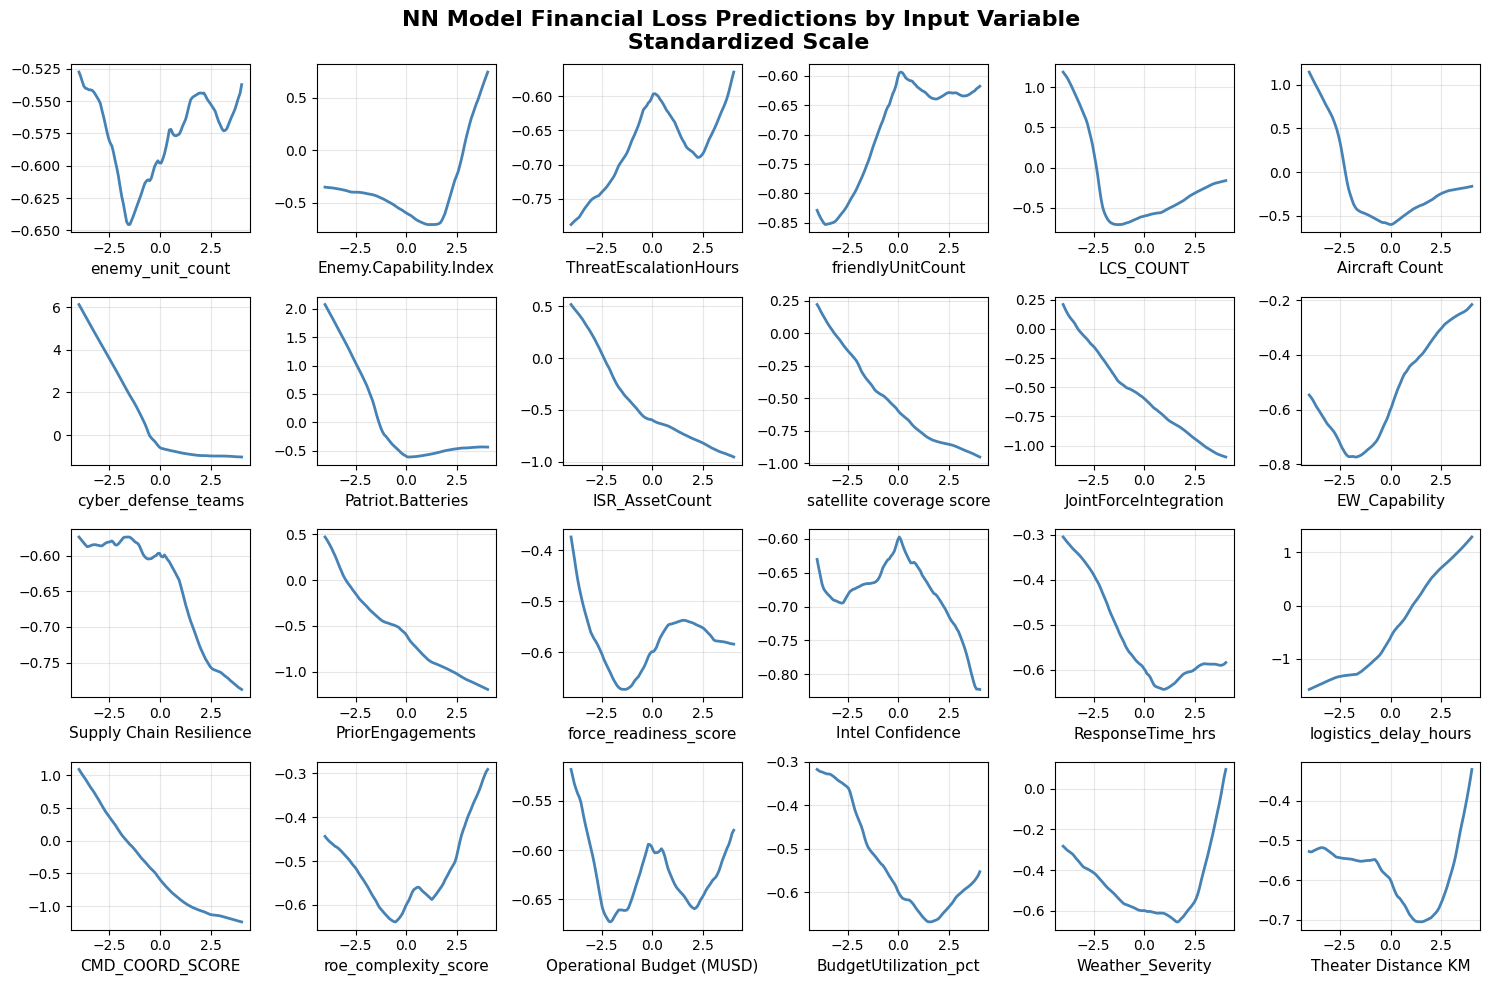

In [19]:
# Visualize nn model: 2D plots of each input vs output
nnmodel.eval() # Set model to evaluation mode

fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()

# For each input variable, create predictions while varying that input
for i, ax in enumerate(axes):
    # Create a range of values for the input variable
    input_range = np.linspace(-4, 4, 100)
    
    # Create prediction arrays by holding other inputs at their mean
    predictions = []
    
    for val in input_range:
        # Start with mean normalized values for all inputs
        input_vector = np.mean(inputs_train, axis=0) # should be around zero 
        
        # Vary the current input
        input_vector[i] = val
        
        # Convert to tensor and predict
        input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
        with torch.no_grad():
            pred = nnmodel(input_tensor).item()
        predictions.append(pred)
    
    # Plot
    ax.plot(input_range, predictions, linewidth=2, color='steelblue')
    ax.set_xlabel(input_columns[i], fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('NN Model Financial Loss Predictions by Input Variable \n Standardized Scale', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

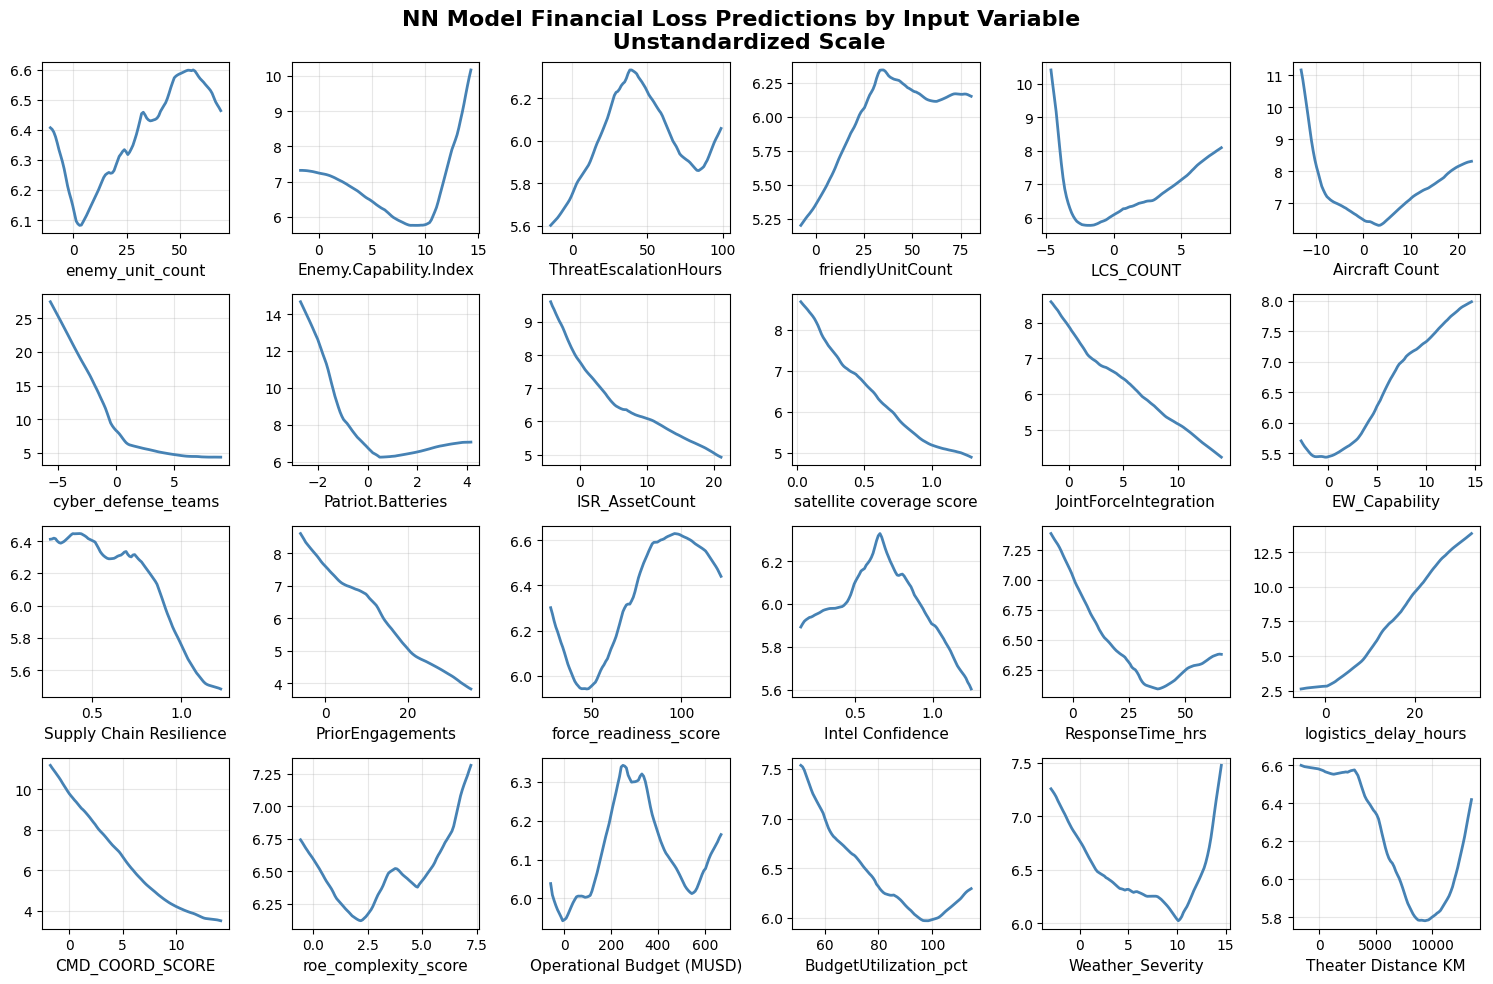

In [20]:
# plots of unstandardized predictions vs unstandardized inputs 
nnmodel.eval()
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()

# For each input variable, create predictions while varying that input
for i, ax in enumerate(axes):
    # Create a range of values for the input variable
    input_range = np.linspace(-2.5, 3, 100)
    
    # Create prediction arrays by holding other inputs at their mean
    predictions = []
    
    for val in input_range:
        # Start with mean normalized values for all inputs
        input_vector = np.mean(inputs_train, axis=0) # should be around zero 
        
        # Vary the current input
        input_vector[i] = val
        
        # Convert to tensor and predict
        input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
        with torch.no_grad():
            pred = nnmodel(input_tensor).item()
        predictions.append(pred)

    # unstandardize 
    input_range = input_range * train_input_stds[i] + train_input_means[i]
    predictions = np.array(predictions) * train_output_std + train_output_mean

    # Plot
    ax.plot(input_range, predictions, linewidth=2, color='steelblue')
    ax.set_xlabel(input_columns[i], fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('NN Model Financial Loss Predictions by Input Variable \n Unstandardized Scale', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


    

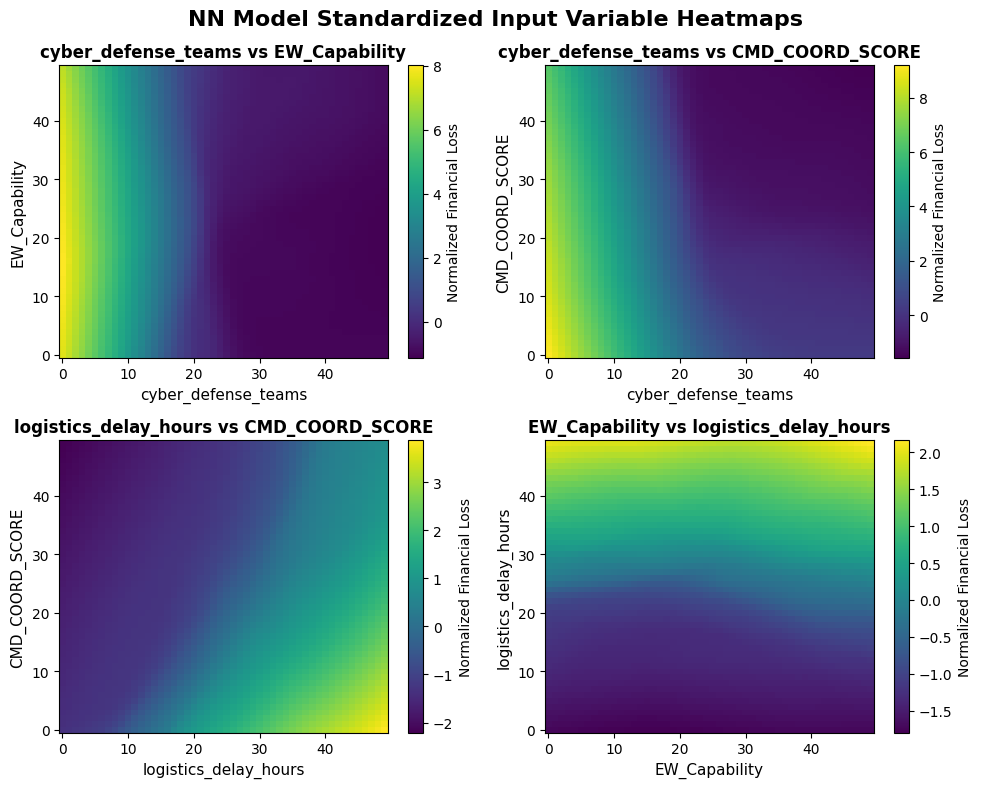

In [21]:
# Create 2D heatmaps for key input pairs
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Define pairs to visualize (most important interactions)
pairs = [(0, 1), (0, 3), (2, 3), (1, 2)]

for plot_idx, (i, j) in enumerate(pairs):
    ax = axes[plot_idx]
    
    # Create grid of values
    input_range = np.linspace(-5, 5, 50)
    heatmap = np.zeros((len(input_range), len(input_range)))
    
    # Fill heatmap by varying inputs i and j
    for x_idx, x_val in enumerate(input_range):
        for y_idx, y_val in enumerate(input_range):
            input_vector = np.mean(inputs_train, axis=0)
            input_vector[input_columns.index(input_names[i])] = x_val
            input_vector[input_columns.index(input_names[j])] = y_val
            
            input_tensor = torch.tensor(input_vector).float().unsqueeze(0)
            with torch.no_grad():
                pred = nnmodel(input_tensor).item()
            heatmap[y_idx, x_idx] = pred
    
    # Plot heatmap with color scale
    im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='viridis')
    ax.set_xlabel(input_names[i], fontsize=11)
    ax.set_ylabel(input_names[j], fontsize=11)
    ax.set_title(f'{input_names[i]} vs {input_names[j]}', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Financial Loss')

plt.suptitle('NN Model Standardized Input Variable Heatmaps', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
def calculate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"R² Score: {r2:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")  
    return mae, r2, rmse, mape

In [23]:
nnmodel.eval()

predictions = []
true_values = []

# calculate mean square error on train dataset 
with torch.no_grad():
    for data, labels in DataLoader(test_dataset, batch_size=32):
        outputs = nnmodel(data)
        predictions.extend(outputs.numpy().flatten())
        true_values.extend(labels.numpy().flatten())

predictions = np.array(predictions)
true_values = np.array(true_values)

# Calculate metrics
calculate_metrics(true_values, predictions) 


Mean Absolute Error (MAE): 0.328860
Root Mean Squared Error (RMSE): 0.429174
R² Score: 0.830675
Mean Absolute Percentage Error (MAPE): 160.05%


(0.3288602828979492,
 0.8306747674942017,
 np.float64(0.42917406444593137),
 np.float32(160.05214))

In [24]:
# calculate metrics on original (unstandardized) scale
predictions_unstd = predictions * (train_output_std) + train_output_mean
true_values_unstd = true_values * (train_output_std) + train_output_mean

# Calculate metrics
calculate_metrics(true_values_unstd, predictions_unstd)

Mean Absolute Error (MAE): 1.663247
Root Mean Squared Error (RMSE): 2.170595
R² Score: 0.830675
Mean Absolute Percentage Error (MAPE): 26.15%


(1.6632474978949316,
 0.830674764108555,
 np.float64(2.170595480923872),
 np.float64(26.14652603470612))